# Objective
Assess the fraction of expert annotations needed to get good precision and recall.

# Takeaways
Keep in mind that since each bootstrap sample is randomly sampled from all the expert annotations, we're getting some little spots, some big spots, with total randomness. In reality, if an expert were told e.g. "Oh, just click 50% of the spots," the expert would probably only click the brightest ones.

In [1]:
from math import sqrt
from math import floor
from scipy import optimize
from skimage import data
from skimage.feature import blob_log
from skimage.color import rgb2gray
from skimage.io import imread
from sklearn.neighbors import KDTree
from numpy import pi, r_
import matplotlib.pyplot as plt
import numpy as np
import math, random, sys
sys.path.insert(0, '../../FISH-annotation/Annotation')
import util

Cell below from https://scipy-cookbook.readthedocs.io/items/FittingData.html.

In [2]:
def gaussian(height, center_x, center_y, width_x, width_y):
    """Returns a gaussian function with the given parameters"""
    width_x = float(width_x)
    width_y = float(width_y)
    return lambda x,y: height*np.exp(
                -(((center_x-x)/width_x)**2+((center_y-y)/width_y)**2)/2)

def moments(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution by calculating its
    moments """
    total = data.sum()
    X, Y = np.indices(data.shape)
    x = (X*data).sum()/total
    y = (Y*data).sum()/total
    col = data[:, int(y)]
    width_x = np.sqrt(np.abs((np.arange(col.size)-y)**2*col).sum()/col.sum())
    row = data[int(x), :]
    width_y = np.sqrt(np.abs((np.arange(row.size)-x)**2*row).sum()/row.sum())
    height = data.max()
    return height, x, y, width_x, width_y

def fitgaussian(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution found by a fit"""
    params = moments(data)
    errorfunction = lambda p: np.ravel(gaussian(*p)(*np.indices(data.shape)) -
                                 data)
    p, success = optimize.leastsq(errorfunction, params)
    return p

### Set bootstrapping experiment params

In [3]:
img_path = 'smfish.png'
img_height = 450
ref_coords_path = 'smfish_coords_with_header.csv'
ref_coords_bare_path = 'smfish_coords.csv'

fraction_list = np.arange(0.1, 1.1, 0.1)
num_trials = 5				# number of trials per fraction
margin = 4					# margin around each spot, in pixels
thresholds = np.arange(0.02, 0.18, 0.005)
correctness_threshold = 4

### Run bootstrapping experiment

In [4]:
im = imread(img_path)
im = rgb2gray(im)
ref_coords = np.genfromtxt(ref_coords_bare_path, delimiter=',')
coords = ref_coords
ref_kdt = util.csv_to_kdt(ref_coords_path, img_height)

precision_list_list = []	# one precision list for each fraction
recall_list_list = []		# one recall list for each fraction

for fraction in fraction_list:
    precision_list = []
    recall_list = []
    for trial_index in range(num_trials):
        
        print('Fraction ' + str(round(fraction, 1)) + ' trial ' + str(trial_index))
 
        # sample a fraction of the expert annotations
        num_to_sample = floor(fraction * len(coords))
        indices = random.sample(range(len(coords)), num_to_sample)
        coords_sampled = [coords[index] for index in indices]
        
        # run parameter extraction to get intensity and sigma_max value for each spot
        #     imagining that only that coords_sampled exists
        
        sigma_max_list = []
        
        for x, y in coords_sampled:
            
            x_min = int(x)-margin if int(x)-margin >= 0 else 0
            x_max = int(x)+margin if int(x)+margin < im.shape[1] else im.shape[1]-1
            y_min = int(y)-margin if int(y)-margin >= 0 else 0
            y_max = int(y)+margin if int(y)+margin < im.shape[0] else im.shape[0]-1

            crop = im[y_min:y_max, x_min:x_max]
            params = fitgaussian(crop)
            fit = gaussian(*params)
            (height, x_param, y_param, width_x, width_y) = params
            sigma_max = math.sqrt(max(width_x, width_y)/2)
            sigma_max_list.append(sigma_max)
            
        max_sigma = max(sigma_max_list)

        # run blob_log(), imagining that only that coords_sampled exists, and save precision and recall values
        
        best_precision_x_recall = 0
        
        for threshold in thresholds:
            blobs_log = blob_log(im, max_sigma=10, num_sigma=10, threshold=threshold)
            blobs_list = []
            for r, c, sigma in blobs_log:
                blobs_list.append([c, r])
            blobs_kdt = KDTree(blobs_list, leaf_size=2, metric='euclidean')	# kdt is a kd tree with all the reference points

            num_blobs_total = len(blobs_log)
            num_ref_total = len(ref_coords)

            correct_blobs = []
            incorrect_blobs = []
            detected_ref = []
            undetected_ref = []

            # correct vs. incorrect

            for r, c, sigma in blobs_log:
                dist, ind = ref_kdt.query([[c, img_height-r]], k=1)
                if dist[0][0] < correctness_threshold:
                    correct_blobs.append((r, c, sigma))
                else:
                    incorrect_blobs.append((r, c, sigma))

            # detected vs. undetected

            for x, y in ref_coords:
                dist, ind = blobs_kdt.query([[x, y]], k=1)
                if dist[0][0] < correctness_threshold:
                    detected_ref.append([x, y])
                else:
                    undetected_ref.append([x, y])

            num_ref_detected = len(detected_ref)
            num_blobs_correct = len(correct_blobs)

            # calculate precision and recall and see if this is the best precision_x_recall we've found yet

            precision = len(correct_blobs)/(len(correct_blobs)+len(incorrect_blobs))
            recall = len(detected_ref)/(len(detected_ref)+len(undetected_ref))
            if (precision * recall) > best_precision_x_recall:
                best_precision_x_recall = precision * recall
                best_precision = precision
                best_recall = recall
            
        precision_list.append(best_precision)
        recall_list.append(best_recall)
        
        print('Best precision =\t' + str(round(best_precision, 2)))
        print('Best recall =\t\t' + str(round(best_recall, 2)))
            
    precision_list_list.append(precision_list)
    recall_list_list.append(recall_list)

Fraction 0.1 trial 0


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/optimize/minpack.py:427: RuntimeWarning: Number of calls to function has reached maxfev = 1200.
  warnings.warn(errors[info][0], RuntimeWarning)


Best precision =	0.98
Best recall =		0.95
Fraction 0.1 trial 1
Best precision =	0.98
Best recall =		0.95
Fraction 0.1 trial 2
Best precision =	0.98
Best recall =		0.95
Fraction 0.1 trial 3
Best precision =	0.98
Best recall =		0.95
Fraction 0.1 trial 4
Best precision =	0.98
Best recall =		0.95
Fraction 0.2 trial 0
Best precision =	0.98
Best recall =		0.95
Fraction 0.2 trial 1
Best precision =	0.98
Best recall =		0.95
Fraction 0.2 trial 2
Best precision =	0.98
Best recall =		0.95
Fraction 0.2 trial 3
Best precision =	0.98
Best recall =		0.95
Fraction 0.2 trial 4
Best precision =	0.98
Best recall =		0.95
Fraction 0.3 trial 0
Best precision =	0.98
Best recall =		0.95
Fraction 0.3 trial 1
Best precision =	0.98
Best recall =		0.95
Fraction 0.3 trial 2
Best precision =	0.98
Best recall =		0.95
Fraction 0.3 trial 3
Best precision =	0.98
Best recall =		0.95
Fraction 0.3 trial 4
Best precision =	0.98
Best recall =		0.95
Fraction 0.4 trial 0
Best precision =	0.98
Best recall =		0.95
Fraction 0.4 

# Plotting

### precision vs. fraction of expert annotations sampled

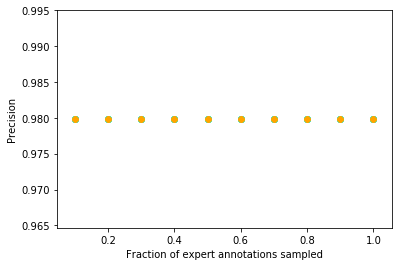

In [6]:
plt.figure()
for ind, fraction in enumerate(fraction_list):
    plt.scatter([fraction]*num_trials, precision_list_list[ind], c='cyan')
    plt.scatter([fraction], [np.mean(precision_list_list[ind])], c='orange')
plt.xlabel('Fraction of expert annotations sampled')
plt.ylabel('Precision')
plt.show()

### precision vs. fraction of expert annotations sampled

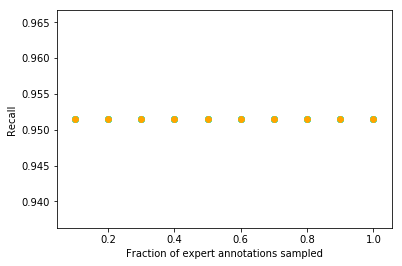

In [8]:
plt.figure()
for ind, fraction in enumerate(fraction_list):
    plt.scatter([fraction]*num_trials, recall_list_list[ind], c='cyan')
    plt.scatter([fraction], [np.mean(recall_list_list[ind])], c='orange')
plt.xlabel('Fraction of expert annotations sampled')
plt.ylabel('Recall')
plt.show()